
##  Implementing Neural Network From Scratch

More often than not, we will use a deep learning library (Tensorflow, Pytorch, or the wrapper known as Keras) to implement our models. However, the abstraction afforded by those libraries can make it hard to troubleshoot issues if we don't understand what is going on under the hood. Here I will implement a fully-connected.  

Implementing a fully-connected neural network from scratch. The neural network will have the following architecture:

- Input layer
- Dense hidden layer with 512 neurons, using relu as the activation function
- Dropout with a value of 0.2
- Dense hidden layer with 512 neurons, using relu as the activation function
- Dropout with a value of 0.2
- Output layer, using softmax as the activation function

The model will use categorical crossentropy as its loss function. 
We will optimize the gradient descent using RMSProp, with a learning rate of 0.001 and a rho value of 0.9.
We will evaluate the model using accuracy.

Why this architecture? We are trying to reproduce from scratch the following [example from the Keras documentation](https://keras.io/examples/mnist_mlp/). This means that you can compare your results by running the Keras code provided above to see if you are on the right track.

In [1]:
import random as rnd
import numpy as np
import sklearn.metrics as sk
import matplotlib.pyplot as plt

def relu(X): 
         #https://medium.com/ai³-theory-practice-business/a-beginners-guide-to-numpy-with-sigmoid-relu-and-softmax-activation-functions-25b840a9a272
        return np.maximum(0,X)

def relu_Derivative(X):
    for i in range(0,X.shape[0],1):
        for j in range(0,X.shape[1],1):
            if X[i][j]>0:
                X[i][j] =1
            else:
                X[i][j]=0
    return X            
            
    
    
def softmax(X):
     
    for i in range(0,len(X),1):
        x_max=max(X[i])
        for j in range(0,len(X[i]),1):
            X[i][j]=X[i][j]-x_max #Normalization: https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
    Exp=np.exp(X)
    for i in range(0,len(X),1):
        expo_sum = np.sum(Exp[i])
        for j in range(0,len(X[i]),1):
            Exp[i][j]=Exp[i][j]/expo_sum
        expo_sum=0
    return Exp 



def drop_out_mask(X,drop_out):
    a=[0,1]
    mask=np.random.choice(a, X.shape,p=[drop_out,1-drop_out])
    return mask*X




def RMS_prop(V_dq,V_db,Q,B,Grad_Q,Grad_B,learning_rate,rho):
    #referred =https://gluon.mxnet.io/chapter06_optimization/rmsprop-scratch.html
    
    eps = 1e-8                       
    V_dq=rho*V_dq+(1-rho)*(np.multiply(Grad_Q,Grad_Q))
    V_db=rho*V_db+(1-rho)*(np.multiply(Grad_B,Grad_B))

    
    Q=Q-(learning_rate*(Grad_Q/np.sqrt( V_dq + eps)))
    B=B-(learning_rate*(Grad_B/np.sqrt( V_db + eps)))
    
    return V_dq,V_db,Q,B

            
def evaluate(Pred,Obsrv):#https://beckernick.github.io/neural-network-scratch/
    

    Pred=np.argmax(Pred, 1)
    preds_correct =  Pred == np.argmax(Obsrv,1)
    correct_predictions = np.sum(preds_correct)
    accuracy = 100.0 * correct_predictions / Pred.shape[0]
    return accuracy

class NeuralNetwork(object):
  def __init__(self,epochs, learning_rate):
    
    self.epochs=epochs
    
    pass



  def feed_forward(self,X,Y,Q1,Q2,Q3,B1,B2,B3,drop_out):
        

    #Layer 1
        Z1=Q1.dot(X)+B1
        A1=relu(Z1)
        A1=drop_out_mask(A1,drop_out)

    #Layer 2
        Z2=(Q2).dot(A1)+B2
        A2=relu(Z2)
        A2=drop_out_mask(A2,drop_out)

    #Layer 3
        Z3=(Q3).dot(A2)+B3
        A3=softmax(Z3.T)
        

        return A1,A2,A3,Z1,Z2,Z3
        
  def back_prop(self,Q1,Q2,Q3,B1,B2,B3,A1,A2,A3,Z1,Z2,Z3,X,Y):

        
        #error at layer 3(output) 
        Err3=(A3-Y).T # Formula reference: https://peterroelants.github.io/posts/cross-entropy-softmax/
        
        #error at layer 2
        Err2=np.multiply(Q3.T.dot(Err3),relu_Derivative(Z2))
        
        #error at layer 1
        Err1=np.multiply(Q2.T.dot(Err2),relu_Derivative(Z1))
    
        ##Computing weight gradients for layer3 (Output)
        Q3_Grad=(Err3.dot(A2.T))/(X.shape[1])
        B3_Grad=Err3.sum(axis=1).reshape(len(B3),1)/(X.shape[1])
        
        ##Computing weight gradients for layer3 (Output)
        Q2_Grad=(Err2.dot(A1.T))/(X.shape[1])
        B2_Grad=Err2.sum(axis=1).reshape(len(B2),1)/(X.shape[1])
        
        ##Computing weight gradients for layer3 (Output)
        Q1_Grad=(Err1.dot(X.T))/(X.shape[1])
        B1_Grad=(Err1.sum(axis=1).reshape(len(B1),1)/(X.shape[1]))

        
        
        return Q1_Grad,Q2_Grad,Q3_Grad,B1_Grad,B2_Grad,B3_Grad
    
        
              
  
  def fit(self,X,Y,drop_out,batch_num,x_test=None,y_test=None):
        batch_size=500
        #layer size
        neu=512
        X_data=X
        Y_data=Y
        X=X[:,:batch_size]
        Y=Y[:batch_size,:]
        
        # He Weight Initialize randomization 
        #Reference:https://medium.com/@prateekvishnu/xavier-and-he-normal-he-et-al-initialization-8e3d7a087528
        Q1=np.random.randn(neu,X.shape[0])*np.sqrt(2/X.shape[0]) # 512*60000
        Q2=np.random.randn(neu,neu)*np.sqrt(2/neu)# 512* 512
        Q3=np.random.randn(Y[0].shape[0],neu)*np.sqrt(2/neu)# 10*512
        
        #Bias Initialization with near zero
        B1=np.ones((Q1.shape[0],1))*0.01 
        B2=np.ones((Q2.shape[0],1))*0.01
        B3=np.ones((Q3.shape[0],1))*0.01

        
        #inintialize for rms prop
        V_dq1=np.zeros((Q1.shape))
        V_dq2=np.zeros((Q2.shape))
        V_dq3=np.zeros((Q3.shape))
        V_db1=np.zeros((B1.shape))
        V_db2=np.zeros((B2.shape))
        V_db3=np.zeros((B3.shape))
        
        #epoch
        for j in range(0,self.epochs,1):
            print("epoch"+str(j))

            for i in range(0,batch_num,1):

                X=X_data[:,i*batch_size:(i*batch_size)+batch_size]
                Y=Y_data[i*batch_size:(i*batch_size)+batch_size,:]
               
                
                #Feed Forward
                A1,A2,A3,Z1,Z2,Z3=self.feed_forward(X,Y,Q1,Q2,Q3,B1,B2,B3,drop_out)

                
                #Back Prop
                Q1_Grad,Q2_Grad,Q3_Grad,B1_Grad,B2_Grad,B3_Grad=self.back_prop(Q1,Q2,Q3,B1,B2,B3,A1,A2,A3,Z1,Z2,Z3,X,Y)
               
    
    
                #RMS Prop
    
                V_dq1,V_db1,Q1,B1=RMS_prop(V_dq1,V_db1,Q1,B1,Q1_Grad,B1_Grad,0.001,0.9)
                V_dq2,V_db2,Q2,B2=RMS_prop(V_dq2,V_db2,Q2,B2,Q2_Grad,B2_Grad,0.001,0.9)
                V_dq3,V_db3,Q3,b3=RMS_prop(V_dq3,V_db3,Q3,B3,Q3_Grad,B3_Grad,0.001,0.9)
            
            if x_test is not None:
                
                A1_train,A2_train,A3_train,Z1_train,Z2_train,Z3_train=self.feed_forward(X_data,Y_data,Q1,Q2,Q3,B1,B2,B3,drop_out)   
                Score_train=evaluate(Y_data, A3_train)
                
                # loss func
                Tot_Loss=0
                for i in range(0,X_data.shape[1],1):
                    Loss_func=-(np.log(A3_train[i]).dot(Y_data[i].T))
                    Tot_Loss=Tot_Loss+Loss_func

                Loss.append(Tot_Loss/X_data.shape[1]) 
                Iteration.append(j)
                
                A1_test,A2_test,A3_test,Z1_test,Z2_test,Z3_test=self.feed_forward(x_test,y_test,Q1,Q2,Q3,B1,B2,B3,drop_out)
                Score_test=evaluate(y_test, A3_test)
                print("Train accuracy :"+str(Score_train)+" Loss :"+str(Tot_Loss/X_data.shape[1])+" Test accuracy :"+str(Score_test))
            else:
                
                #Evaluate
                Score=evaluate(Y, A3)
                print("accuracy"+str(Score))
    
    

        return Q1,Q2,Q3,B1,B2,B3,A1,A2,A3

    

Train your fully-connected neural network on the Fashion-MNIST dataset using 5-fold cross validation. Report accuracy on the folds, as well as on the test set.

In [2]:
# To simplify the usage of our dataset, we will be importing it from the Keras 
# library. Keras can be installed using pip: python -m pip install keras

# Original source for the dataset:
# https://github.com/zalandoresearch/fashion-mnist

# Reference to the Fashion-MNIST's Keras function: 
# https://keras.io/datasets/#fashion-mnist-database-of-fashion-articles

from keras.datasets import fashion_mnist
import keras

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
# each sample is 28* 28 matrix
#print(x_train[0])

x_train = x_train.reshape(60000, 784)
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(x_train[0].shape[0])
print(y_train[0])

X=x_train.T
Y=y_train
x_test=x_test.T

Using TensorFlow backend.


60000 train samples
10000 test samples
784
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [5]:
#cross validation
def valid_part(X,fold,k):
    n=X.shape[1]
    i=int((n/k)*fold)
    j=int((n/k)*(fold+1))
    Valid_set=X[:,i:j]
    Train_set= (np.concatenate((X[:,:i].T, X[:,j:].T))).T
    return Valid_set,Train_set
    
Loss=[]
Iteration=[]
Train_score=[]
Valid_score=[]
Test_score=[]
def cross_validation(X,Y):
    for fold in range(0,5,1):
        print("###########Cross Validation Set: "+str(fold)+"###############")
        Valid_set,Train_set=valid_part(X,fold,5)
        Valid_label,Train_label=valid_part(Y.T,fold,5)
        Model=NeuralNetwork(20,1)
        batch_num=int(Train_set.shape[1]/500)
        Q1,Q2,Q3,B1,B2,B3,A1,A2,A3=Model.fit(Train_set,Train_label.T,0.2,batch_num)
        A1,A2,A3,Z1,Z2,Z3=Model.feed_forward(Train_set,Train_set.T,Q1,Q2,Q3,B1,B2,B3,0)
        Tr_score=evaluate(Train_label.T,A3)
        Train_score.append(Tr_score)
        A1,A2,A3,Z1,Z2,Z3=Model.feed_forward(Valid_set,Valid_label.T,Q1,Q2,Q3,B1,B2,B3,0)
        V_score=evaluate(Valid_label.T,A3)
        Valid_score.append(V_score)
        print("Train Score :"+str(Tr_score))
        print("Valid_score :"+str(V_score))
        A1_test,A2_test,A3_test,Z1_test,Z2_test,Z3_test=Model.feed_forward(x_test,y_test,Q1,Q2,Q3,B1,B2,B3,0)
        Score_test=evaluate(y_test, A3_test)
        print("Test_score :"+str(Score_test))
        Test_score.append(Score_test)
        
    print("Training Score for 5 fold "+str(Train_score))
    print("Validation Score for 5 fold "+str(Valid_score))
    print("Testing score for 5 fold "+str(Test_score))
        
        
#Cross validation
cross_validation(X,Y)             

###########Cross Validation Set: 0###############
epoch0
accuracy76.0
epoch1
accuracy80.2
epoch2
accuracy81.8
epoch3
accuracy82.4
epoch4
accuracy83.4
epoch5
accuracy83.4
epoch6
accuracy85.4
epoch7
accuracy84.8
epoch8
accuracy87.2
epoch9
accuracy87.8
epoch10
accuracy87.2
epoch11
accuracy87.4
epoch12
accuracy88.2
epoch13
accuracy88.2
epoch14
accuracy87.6
epoch15
accuracy88.6
epoch16
accuracy90.4
epoch17
accuracy88.6
epoch18
accuracy90.2
epoch19
accuracy89.8
Train Score :91.8875
Valid_score :88.89166666666667
Test_score :88.05
###########Cross Validation Set: 1###############
epoch0
accuracy77.4
epoch1
accuracy83.0
epoch2
accuracy82.6
epoch3
accuracy82.2
epoch4
accuracy83.6
epoch5
accuracy86.0
epoch6
accuracy83.6
epoch7
accuracy87.6
epoch8
accuracy85.6
epoch9
accuracy87.8
epoch10
accuracy87.4
epoch11
accuracy88.6
epoch12
accuracy86.0
epoch13
accuracy89.2
epoch14
accuracy89.4
epoch15
accuracy88.2
epoch16
accuracy91.0
epoch17
accuracy90.0
epoch18
accuracy91.0
epoch19
accuracy90.8
Train Scor

epoch0
Train accuracy :79.54666666666667 Loss :0.5431707898507998 Test accuracy :78.36
epoch1
Train accuracy :81.89333333333333 Loss :0.5045496815885411 Test accuracy :80.44
epoch2
Train accuracy :84.79333333333334 Loss :0.3990065194805477 Test accuracy :83.32
epoch3
Train accuracy :84.96166666666667 Loss :0.39241004516647304 Test accuracy :83.4
epoch4
Train accuracy :87.53166666666667 Loss :0.32863506619528715 Test accuracy :85.42
epoch5
Train accuracy :87.91333333333333 Loss :0.3166613761735594 Test accuracy :85.93
epoch6
Train accuracy :88.18666666666667 Loss :0.31273377589069823 Test accuracy :85.89
epoch7
Train accuracy :88.45166666666667 Loss :0.30170864379195705 Test accuracy :86.2
epoch8
Train accuracy :89.965 Loss :0.2642814247335282 Test accuracy :87.13
epoch9
Train accuracy :89.55 Loss :0.2747081741826826 Test accuracy :86.73
epoch10
Train accuracy :90.285 Loss :0.252073289399758 Test accuracy :87.68
epoch11
Train accuracy :90.425 Loss :0.24795265389323407 Test accuracy :87.

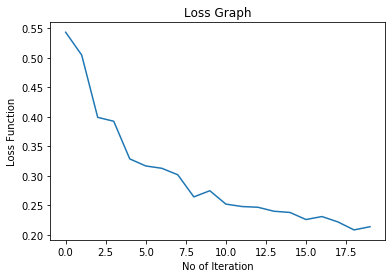

In [7]:
#fitting
Loss=[]
Iteration=[]
N=NeuralNetwork(20,1)
batch_num=int(X.shape[1]/500)
Q1,Q2,Q3,B1,B2,B3,A1,A2,A3=N.fit(X,Y,0.2,batch_num,x_test,y_test)
print("fit")

#graph
fig, ax = plt.subplots()
ax.plot(Iteration,Loss)
ax.set_xlabel('No of Iteration')
ax.set_ylabel('Loss Function')
ax.set_title('Loss Graph')
plt.show()
                   